# Deep Learning - Final Assignment
FinalGroup3: Aro-Sati, Leila; François, Hanne; Ibragimova, Regina; Karimi, Kasra; Wieme, Xander


In [1]:
# Update keras to version 3
!pip install keras keras-tuner  --upgrade  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import pandas as pd
import seaborn as sns

import os
from os.path import basename, isdir
from PIL import Image
import numpy as np
import gdown
import shutil

import keras_tuner

import keras
from keras.utils import load_img, img_to_array, to_categorical
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale, normalize
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from zipfile import ZipFile

# Introduction
This the HAM10000 ("Human Against Machine with 10000 training images") dataset. It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma

# Data loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
skin_df = pd.read_csv('/content/drive/MyDrive/DL_FinalProject/data/HAM10000_metadata.csv')

# Data preprocessing

In [5]:
image_metadata_mapping = {}
for _, row in skin_df.iterrows():
    image_metadata_mapping[row['image_id']] = row.to_dict()

To be used later for labels:

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Next, the image data is extracted from zip files. Each image is resized from the original dimension of 600x450x3 to 100x75x3 pixels and then rescaled between 0 and 1 by dividing by 255.0. This preprocessing is performed as the images are added to a dictionary named images, with each image's ID serving as the key. By resizing and rescaling the images during the extraction process, memory usage is optimized, as it avoids storing the original large images. This processed image data is mapped to their corresponding IDs in the skin_df.

In [7]:
images = {}
with ZipFile('/content/drive/MyDrive/DL_FinalProject/data/HAM10000_images_part_1.zip') as z:
    for f in z.namelist():
        images[f.rsplit('.', 1)[0]] = np.asarray(Image.open(z.open(f)).resize((100,75))).astype('float32') / 255.0

In [8]:
with ZipFile('/content/drive/MyDrive/DL_FinalProject/data/HAM10000_images_part_2.zip') as z:
    for f in z.namelist():
        images[f.rsplit('.', 1)[0]] = np.asarray(Image.open(z.open(f)).resize((100,75))).astype('float32') / 255.0

In [9]:
skin_df['image'] = skin_df['image_id'].map(images.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[0.74509805, 0.6, 0.7607843], [0.7529412, 0....",Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[0.09019608, 0.050980393, 0.08627451], [0.09...",Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[[[0.7254902, 0.49803922, 0.5372549], [0.74117...",Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[0.09411765, 0.043137256, 0.06666667], [0.10...",Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[[[0.5254902, 0.3529412, 0.44313726], [0.57647...",Benign keratosis-like lesions,2


In [11]:
skin_df.shape

(10015, 10)

# Data cleaning

## Removing duplicates

Grouping by patient id.

In [12]:
skin_df.groupby('lesion_id').size().to_frame('N').value_counts()

N
1    5514
2    1423
3     490
4      34
5       5
6       4
Name: count, dtype: int64

In [13]:
skin_df['lesion_id'].nunique()

7470

We remove all the duplicated images, keeping only the last ones.

In [14]:
skin_df_cleaned = skin_df.drop_duplicates(subset=['lesion_id'], keep='last')

In [15]:
skin_df_cleaned.shape

(7470, 10)

## Imputing missing age

In [16]:
skin_df_cleaned.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
image             0
cell_type         0
cell_type_idx     0
dtype: int64

In [17]:
skin_df_cleaned['age'].fillna((skin_df_cleaned['age'].mean()), inplace=True)

<ipython-input-17-d8c7189d4f80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skin_df_cleaned['age'].fillna((skin_df_cleaned['age'].mean()), inplace=True)


In [18]:
skin_df_cleaned.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
image            0
cell_type        0
cell_type_idx    0
dtype: int64

# Metadata: EDA

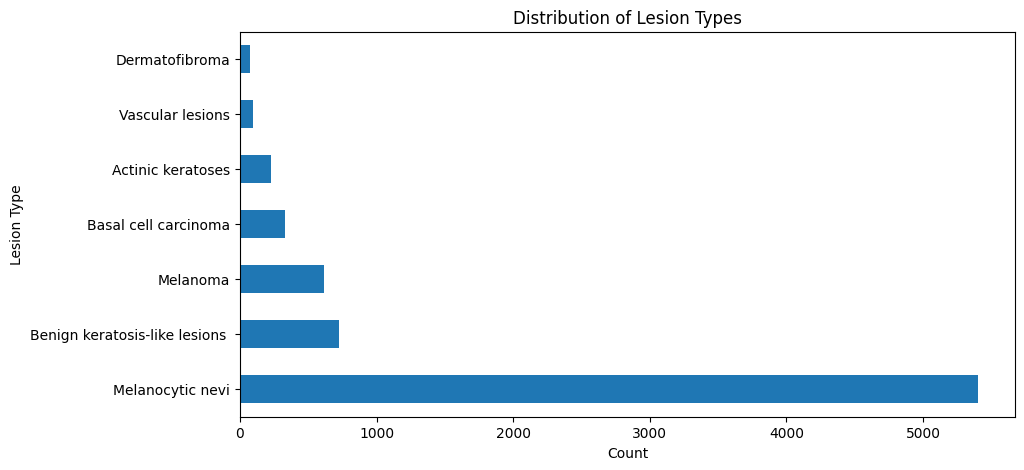

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df_cleaned['cell_type'].value_counts().plot(kind='barh', ax=ax1)

ax1.set_title('Distribution of Lesion Types')
ax1.set_xlabel('Count')
ax1.set_ylabel('Lesion Type')

plt.show()

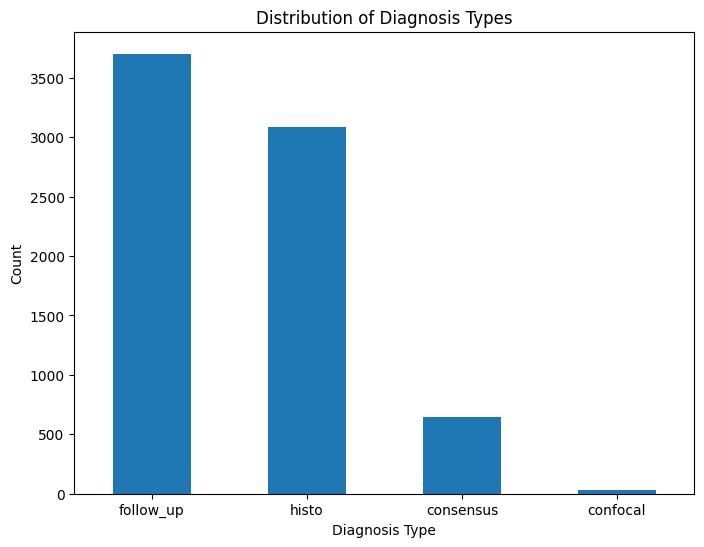

In [ ]:
plt.figure(figsize=(8, 6))
ax = skin_df_cleaned['dx_type'].value_counts().plot(kind='bar')
ax.set_title('Distribution of Diagnosis Types')
ax.set_xlabel('Diagnosis Type')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

<Axes: ylabel='localization'>

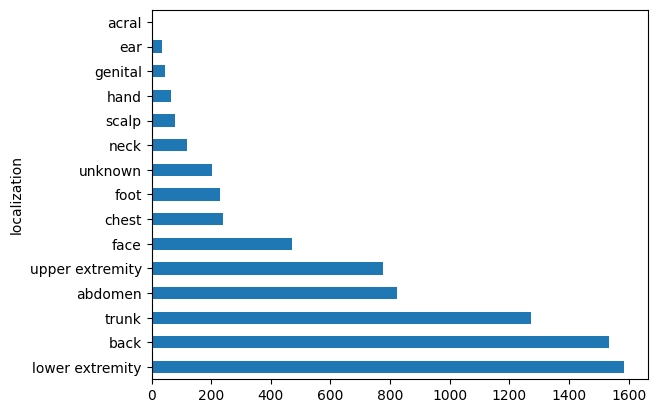

In [ ]:
skin_df_cleaned['localization'].value_counts().plot(kind='barh')

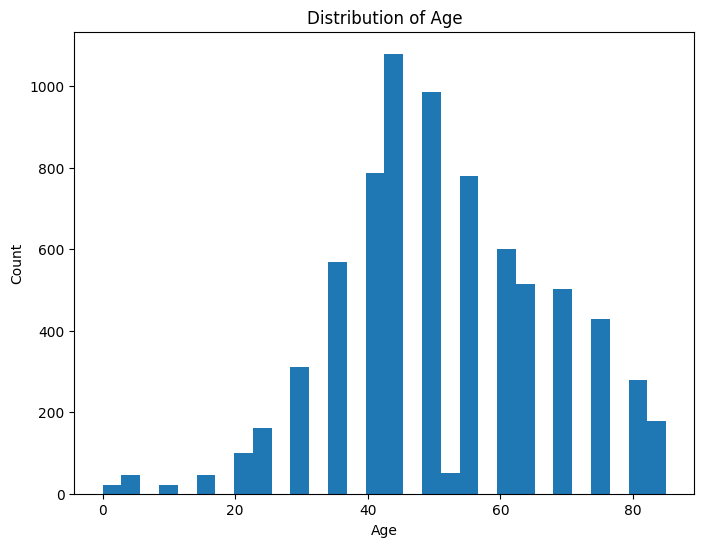

In [ ]:
plt.figure(figsize=(8, 6))
skin_df_cleaned['age'].hist(bins=30)
plt.grid(False)

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

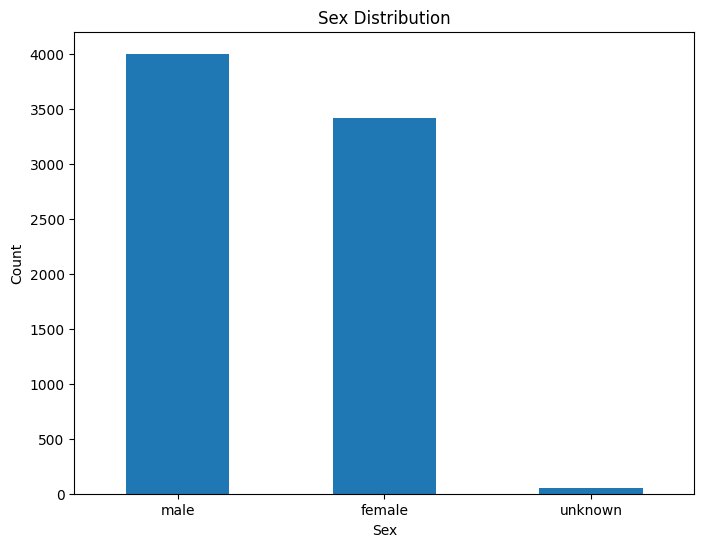

In [ ]:
plt.figure(figsize=(8, 6))
ax = skin_df_cleaned['sex'].value_counts().plot(kind='bar')
ax.set_title('Sex Distribution')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

In [ ]:
skin_df_cleaned.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image,cell_type,cell_type_idx
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[0.09019608, 0.050980393, 0.08627451], [0.09...",Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[0.09411765, 0.043137256, 0.06666667], [0.10...",Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,"[[[0.015686275, 0.0, 0.003921569], [0.02745098...",Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,"[[[0.58431375, 0.4117647, 0.33333334], [0.6117...",Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,"[[[0.8980392, 0.69411767, 0.75686276], [0.9019...",Benign keratosis-like lesions,2


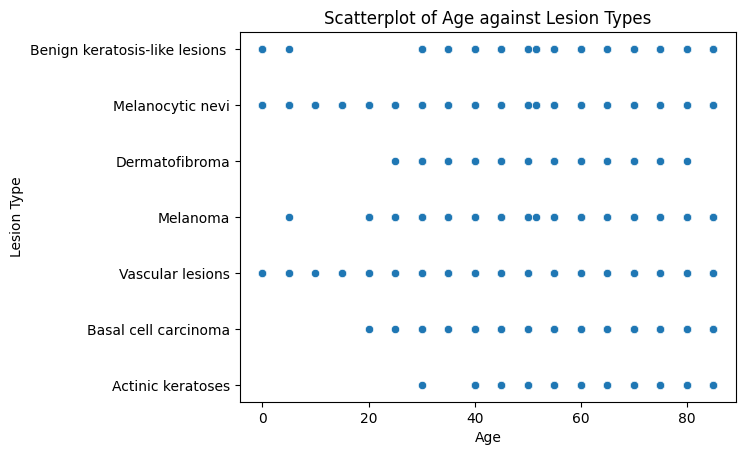

In [ ]:
sns.scatterplot(x='age', y='cell_type', data=skin_df_cleaned)

plt.title('Scatterplot of Age against Lesion Types')
plt.xlabel('Age')
plt.ylabel('Lesion Type')

plt.show()

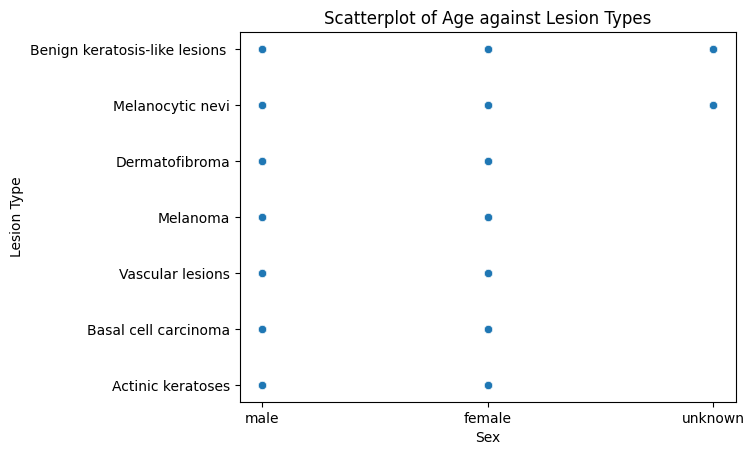

In [ ]:
sns.scatterplot(x='sex', y='cell_type', data=skin_df_cleaned)

plt.title('Scatterplot of Age against Lesion Types')
plt.xlabel('Sex')
plt.ylabel('Lesion Type')

plt.show()

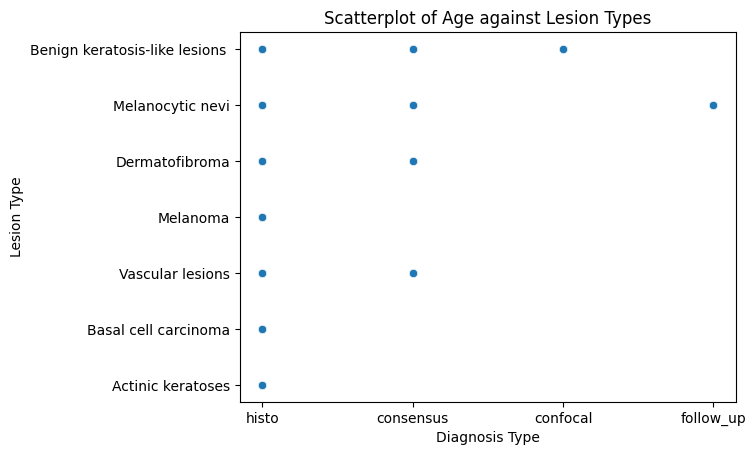

In [ ]:
sns.scatterplot(x='dx_type', y='cell_type', data=skin_df_cleaned)

plt.title('Scatterplot of Age against Lesion Types')
plt.xlabel('Diagnosis Type')
plt.ylabel('Lesion Type')

plt.show()

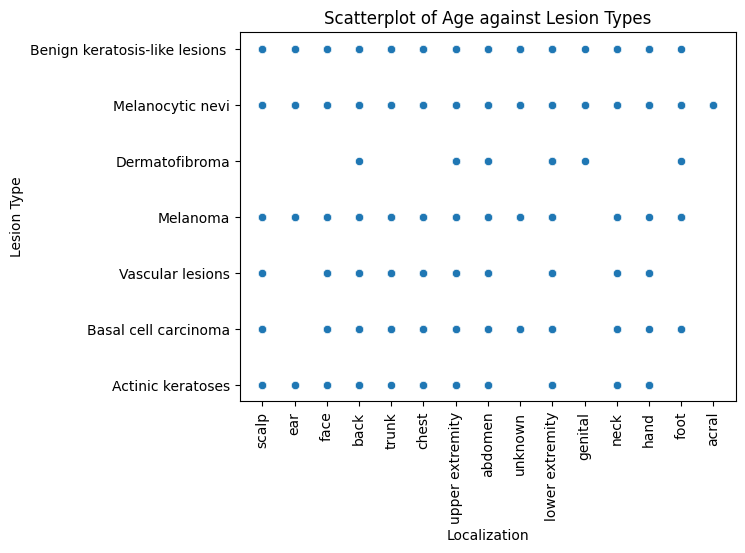

In [ ]:
sns.scatterplot(x='localization', y='cell_type', data=skin_df_cleaned)

plt.title('Scatterplot of Age against Lesion Types')
plt.xlabel('Localization')
plt.ylabel('Lesion Type')
plt.xticks(rotation=90)
plt.show()


# Images: exploration


 Since TensorFlow has limitations with the original image dimensions of 450x600x3, we have already resized them to 100x75 pixels to ensure compatibility.

In [ ]:
# Checking the image size distribution
skin_df_cleaned['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    7470
Name: count, dtype: int64

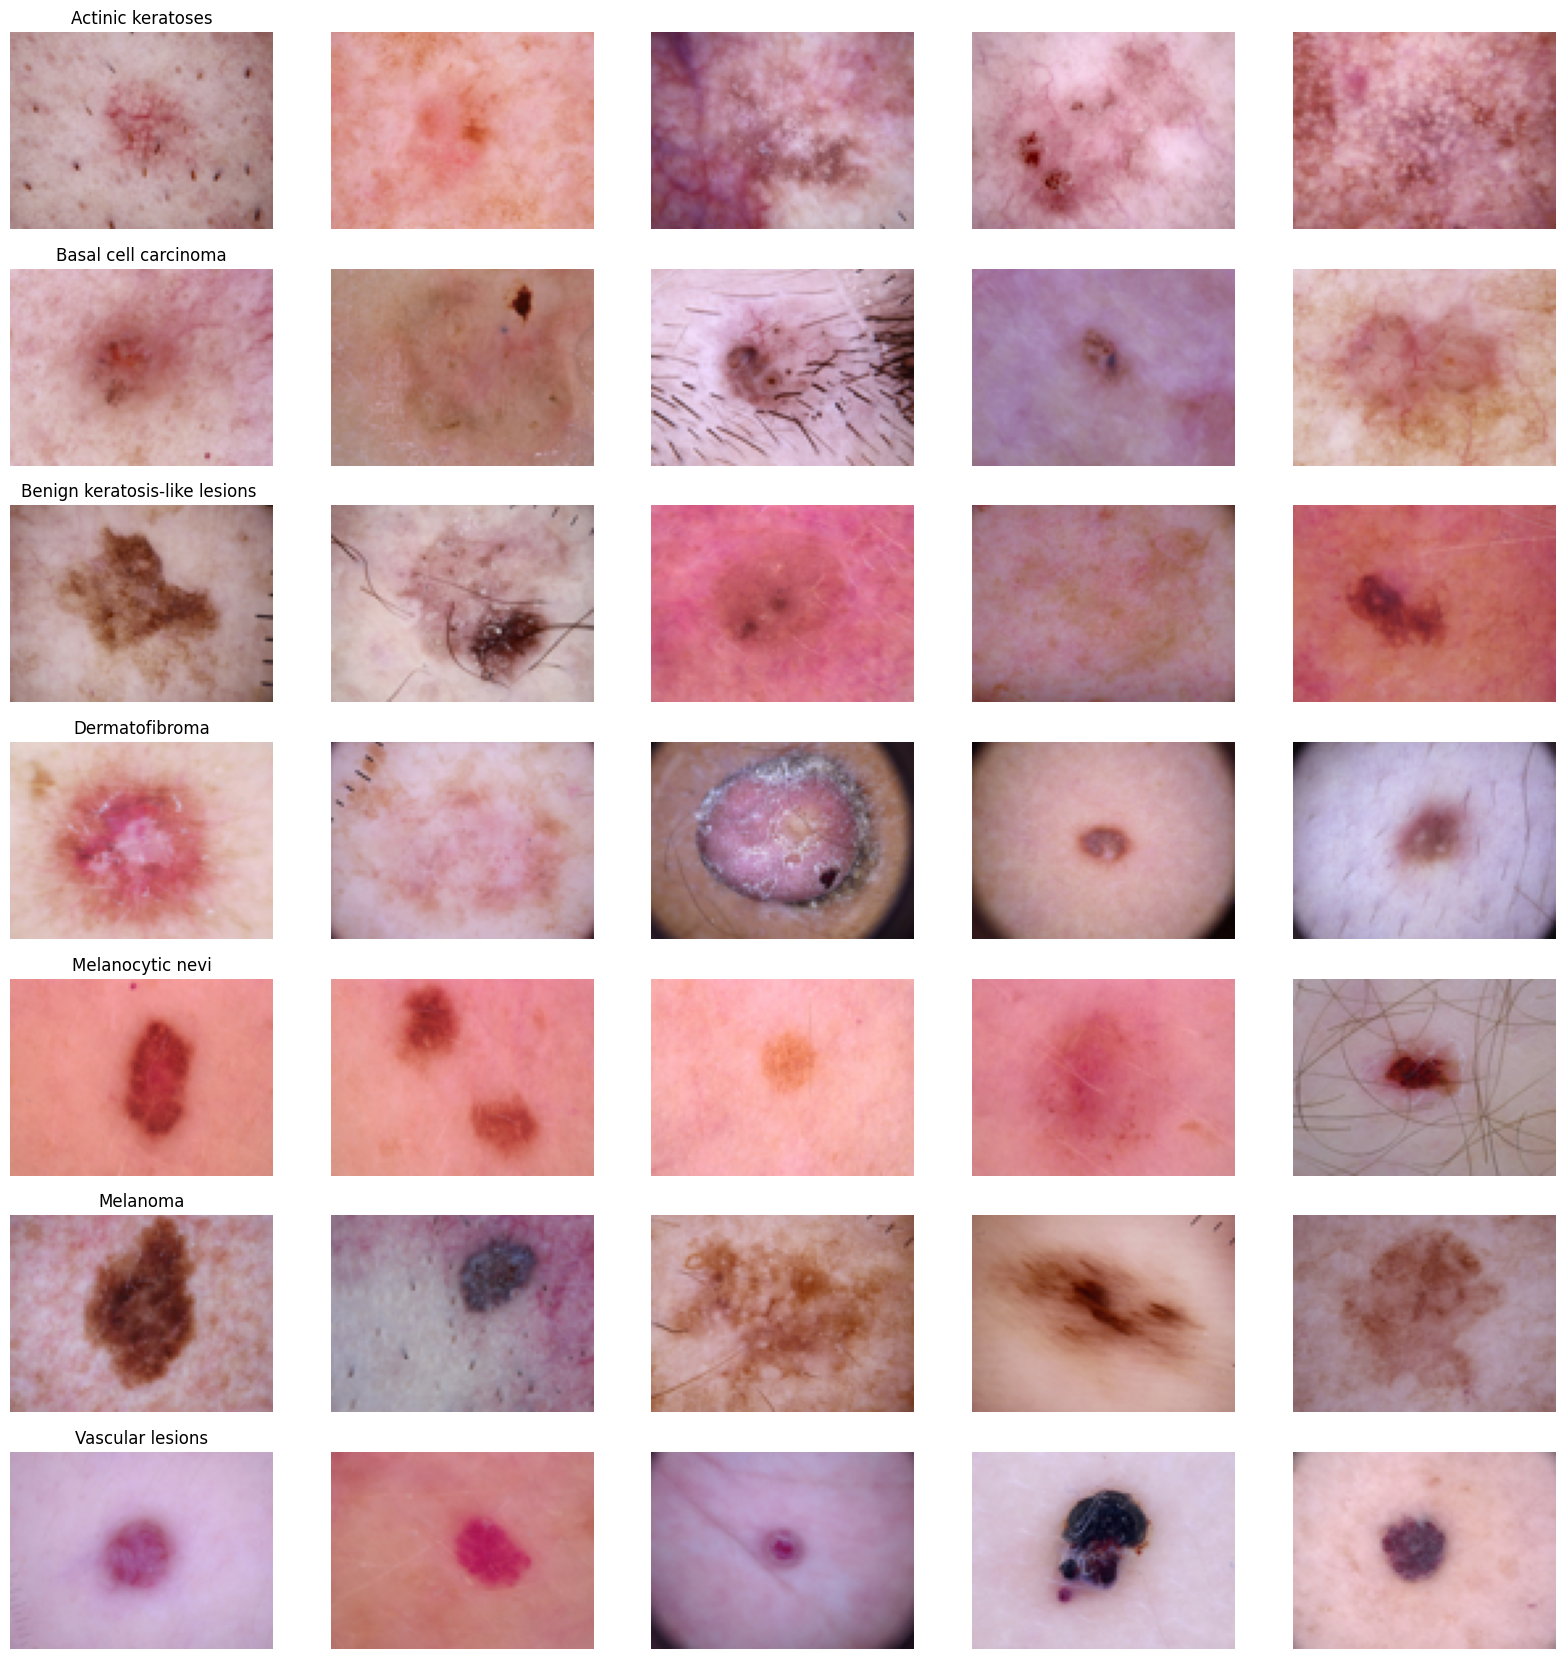

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_cleaned.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig('category_samples.png', dpi=300)

# Data splitting

In [19]:
skin_df_cleaned.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image,cell_type,cell_type_idx
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[0.09019608, 0.050980393, 0.08627451], [0.09...",Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[0.09411765, 0.043137256, 0.06666667], [0.10...",Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,"[[[0.015686275, 0.0, 0.003921569], [0.02745098...",Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,"[[[0.58431375, 0.4117647, 0.33333334], [0.6117...",Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,"[[[0.8980392, 0.69411767, 0.75686276], [0.9019...",Benign keratosis-like lesions,2


In [20]:
features=skin_df_cleaned.drop(columns=['cell_type_idx'],axis=1)
target=skin_df_cleaned['cell_type_idx']

In [21]:
features.shape

(7470, 9)

In [22]:
features.groupby('lesion_id').size().to_frame('N').value_counts()

N
1    7470
Name: count, dtype: int64

In [23]:
target.value_counts()

cell_type_idx
4    5403
2     727
5     614
1     327
0     228
6      98
3      73
Name: count, dtype: int64

We split the images to the train, validation and test datasets with ratio 0.7:0.15:0.15.

In [24]:
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(features, target,
                                                            test_size=0.3,
                                                            stratify=target,
                                                            random_state=42)

X_valid_raw, X_test_raw, y_valid_raw, y_test_raw = train_test_split(X_temp, y_temp,
                                                                    test_size=0.5,
                                                                    stratify=y_temp,
                                                                    random_state=42)

In [25]:
print("Number of images in X_train:", X_train_raw.shape[0])
print("Number of images in X_validation:", X_valid_raw.shape[0])
print("Number of images in X_test:", X_test_raw.shape[0])

Number of images in X_train: 5229
Number of images in X_validation: 1120
Number of images in X_test: 1121


In [ ]:
X_train = X_train_raw['image']
X_valid = X_valid_raw['image']
X_test = X_test_raw['image']

# Label encoding

In [ ]:
y_train = to_categorical(y_train_raw, num_classes = 7)
y_valid = to_categorical(y_valid_raw, num_classes = 7)
y_test = to_categorical(y_test_raw, num_classes = 7)

In [ ]:
class_counts = np.sum(y_train, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 159  (3.04%)
Class 1: 229  (4.38%)
Class 2: 509  (9.73%)
Class 3: 51   (0.98%)
Class 4: 3782 (72.33%)
Class 5: 430  (8.22%)
Class 6: 69   (1.32%)


In [ ]:
class_counts = np.sum(y_valid, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 34   (3.04%)
Class 1: 49   (4.38%)
Class 2: 109  (9.73%)
Class 3: 11   (0.98%)
Class 4: 810  (72.32%)
Class 5: 92   (8.21%)
Class 6: 15   (1.34%)


In [ ]:
class_counts = np.sum(y_test, axis=0)

for i, count in enumerate(class_counts):
    percentage = count / sum(class_counts) * 100
    print(f"Class {i}: {int(count):<4} ({percentage:.2f}%)")

Class 0: 35   (3.12%)
Class 1: 49   (4.37%)
Class 2: 109  (9.72%)
Class 3: 11   (0.98%)
Class 4: 811  (72.35%)
Class 5: 92   (8.21%)
Class 6: 14   (1.25%)


In [ ]:
class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

#Saving the split data

In [ ]:
X_train = np.array(list(X_train_raw['image']))
X_valid = np.array(list(X_valid_raw['image']))
X_test = np.array(list(X_test_raw['image']))

In [ ]:
np.save('/content/drive/My Drive/DL_FinalProject/data/X_train.npy', X_train)
np.save('/content/drive/My Drive/DL_FinalProject/data/y_train.npy', y_train)
np.save('/content/drive/My Drive/DL_FinalProject/data/X_valid.npy', X_valid)
np.save('/content/drive/My Drive/DL_FinalProject/data/y_valid.npy', y_valid)
np.save('/content/drive/My Drive/DL_FinalProject/data/X_test.npy', X_test)
np.save('/content/drive/My Drive/DL_FinalProject/data/y_test.npy', y_test)

In [26]:
def encode(df, sex_encoder, localization_encoder):
  """
  Extract meta data from data frame, encode categorical features as a one hot
  vector and concatenate all meta data features to form one feature vector per
  sample.
  """
  return np.hstack([
        df.age.values.reshape(-1, 1),
        sex_encoder.transform(df.sex.values.reshape(-1, 1)).toarray(),
        localization_encoder.transform(df.localization.values.reshape(-1, 1)).toarray(),
    ])

In [28]:
sex_encoder = OneHotEncoder().fit(X_train_raw.sex.values.reshape(-1, 1))
localization_encoder = OneHotEncoder().fit(X_train_raw.localization.values.reshape(-1, 1))

In [29]:
meta_data_train = encode(X_train_raw, sex_encoder, localization_encoder)
meta_data_valid = encode(X_valid_raw, sex_encoder, localization_encoder)
meta_data_test = encode(X_test_raw, sex_encoder, localization_encoder)

In [33]:
np.save('/content/drive/My Drive/DL_FinalProject/data/meta_data_train.npy', meta_data_train)
np.save('/content/drive/My Drive/DL_FinalProject/data/meta_data_valid.npy', meta_data_valid)
np.save('/content/drive/My Drive/DL_FinalProject/data/meta_data_test.npy', meta_data_test)